In [901]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost
pd.options.display.max_rows = None
pd.options.display.max_columns = None
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Load data
# Loading data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.drop(["Id"],inplace=True,axis=1)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler



In [902]:
no_garage_indx = train[train.GarageYrBlt.isna()].index

## Which numeric features have missing values? 

In [830]:
numeric_features = train.select_dtypes(exclude=["object"])
# Get a Boolean DataFrame indicating missing values
missing_values = numeric_features.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = numeric_features.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for column in columns_with_missing_values:
    count = missing_values_count[column]
    print(f'"{column}" has {count} missing value(s).')

"MasVnrArea" has 8 missing value(s).
"GarageYrBlt" has 81 missing value(s).
"LotFrontage" has 259 missing value(s).


### We will define GarageYrBlt = NaN as YearBuilt, since the house dosen't have garage.
### Same for LotFrontage and MasVnrArea as NaN means no linear feet of street connected to property


In [831]:
train.GarageYrBlt.fillna(0,inplace=True)
train.GarageYrBlt[train.GarageYrBlt == 0] = train.YearBuilt[train.GarageYrBlt == 0]
train.LotFrontage.fillna(0,inplace=True)
train.MasVnrArea.fillna(0,inplace=True)
numeric_features = train.drop(["SalePrice"],axis=1).select_dtypes(exclude=["object"])

C:\Users\yosefos\AppData\Local\Temp\ipykernel_8560\1554693866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.GarageYrBlt[train.GarageYrBlt == 0] = train.YearBuilt[train.GarageYrBlt == 0]


## Cleaning missing values in categorical features

In [832]:
categorical_features = train.select_dtypes(include=["object"])
# Get a Boolean DataFrame indicating missing values
missing_values = categorical_features.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = categorical_features.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for column in columns_with_missing_values:
    count = missing_values_count[column]
    print(f'"{column}" has {count} missing value(s).')


"Electrical" has 1 missing value(s).
"MasVnrType" has 8 missing value(s).
"BsmtQual" has 37 missing value(s).
"BsmtCond" has 37 missing value(s).
"BsmtFinType1" has 37 missing value(s).
"BsmtExposure" has 38 missing value(s).
"BsmtFinType2" has 38 missing value(s).
"GarageType" has 81 missing value(s).
"GarageFinish" has 81 missing value(s).
"GarageQual" has 81 missing value(s).
"GarageCond" has 81 missing value(s).
"FireplaceQu" has 690 missing value(s).
"Fence" has 1179 missing value(s).
"Alley" has 1369 missing value(s).
"MiscFeature" has 1406 missing value(s).
"PoolQC" has 1453 missing value(s).


### Electrical:  Missing was set to the mode of neighborhood its neighborhood

#### The remainings features  contain NaN values because they represent a qualitative measurement of a property that doesn't exist. For instance, if a row has a value of 0 for 'Fireplaces', then 'FireplaceQu' will also be NaN. To make it easier to work with the data later, I've converted all these NaN values to the string "Na".

In [833]:
# Electricity
most_common_in_neigh = categorical_features[(categorical_features['Neighborhood'] == categorical_features.loc[1379]['Neighborhood'])]["Electrical"].value_counts().index[0]
categorical_features.loc[1379, 'Electrical']  = most_common_in_neigh


## Remaining


# Get a Boolean DataFrame indicating missing values
missing_values = categorical_features.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = categorical_features.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for col in columns_with_missing_values: # columns related to garage and basement
    
    categorical_features[col].fillna("Na", inplace=True)


## Splitting data into categorical, continuous and ordinal.

In [834]:
continuous_features = numeric_features[ ['MiscVal',"LotFrontage", 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                                         'LowQualFinSF','GrLivArea','GarageArea', 'WoodDeckSF','OpenPorchSF','3SsnPorch','EnclosedPorch', 'ScreenPorch', 'PoolArea'] ].copy()

discrete_features = numeric_features[list(set(numeric_features.columns) - set(continuous_features.columns))].copy()

categorical_features["MSSubClass"] = discrete_features.MSSubClass
discrete_features.drop("MSSubClass",axis=1,inplace=True)

categorical_features["MoSold"] = discrete_features.MoSold
discrete_features.drop("MoSold",axis=1,inplace=True)

#### Idea #1 : decide which features in categorical are ordinary in nature, and which aren't. The ideea is to assaign values to ordinary features (like 'OverallCond') and one-hot-enconding to true categorical features.

#### Idea  #2 : remove features where one category has much more counts than the others, making this feature informationless.

#### A drawback to this is that we perhaps loss information about edge cases: this is fine however, as first i am trying to make a simple generic model.



## <ins> Idea 1

### After inspection, the next features were chosen as ordinal features:

##### 'ExterCond','ExterQual', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
##### 'HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual'


### <ins> Remark: Many of this features has Na in it, which is not strictly ordinal

### We will check if having basement in general is better than having no basement, and if os. we can rank Na as lowest. same for garage

### The general trend is that indeed no garage or basment lowers the price of the house, so we will assign the lowest value to Na 

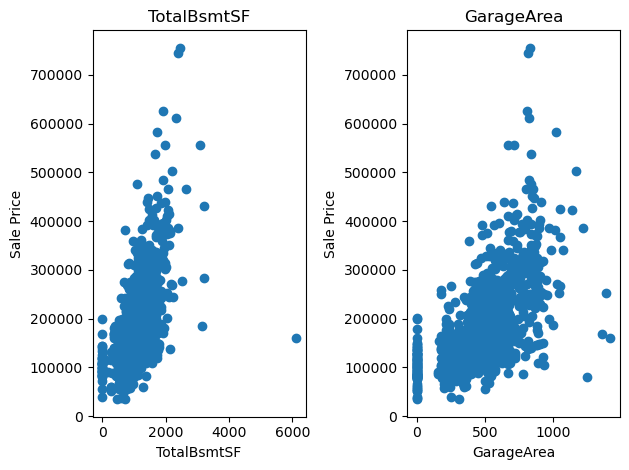

In [835]:
columns = ['TotalBsmtSF','GarageArea']

for i,col in enumerate(columns):
    plt.subplot(1,2,i+1)
    x = numeric_features[col]
    y = train.SalePrice.values
    plt.scatter(x,y)
    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.xlabel(col)
    plt.ylabel("Sale Price")

# Show the plot

plt.tight_layout()

## Change GarageYrBLt = 0 to YearBlt
## Add Bedroom

## Splitting categorical features to ordinal and categorical

In [836]:
columns = ['ExterCond','ExterQual', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual']
ordinal_features = categorical_features[columns].copy()

categorical_features.drop(columns,axis=1,inplace=True)

mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Na': 0,
    'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1,
    'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,
    'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0,
    'Fin': 3, 'RFn': 2, 'Unf': 1}


for col in columns:
    ordinal_features[col] = ordinal_features[col].map(mapping)


#### Lastly we need to convert features with int dtype to string and to one-hot-encode the categorical data:

In [837]:
int_cols = categorical_features.select_dtypes(include='int').columns
# Change datatype of all integer columns to string
categorical_features[int_cols] = categorical_features[int_cols].astype(str)

# get dummies
one_hot_categorical_features = pd.get_dummies(categorical_features)

## <ins>So far:
#### We have split the data into 4:
1. Continuous data
2. Discrete numerical
3. Oridnal
4. Categorical

## <ins>Looking deeper into discrete feautres:


### Plotting features vs SalePrice

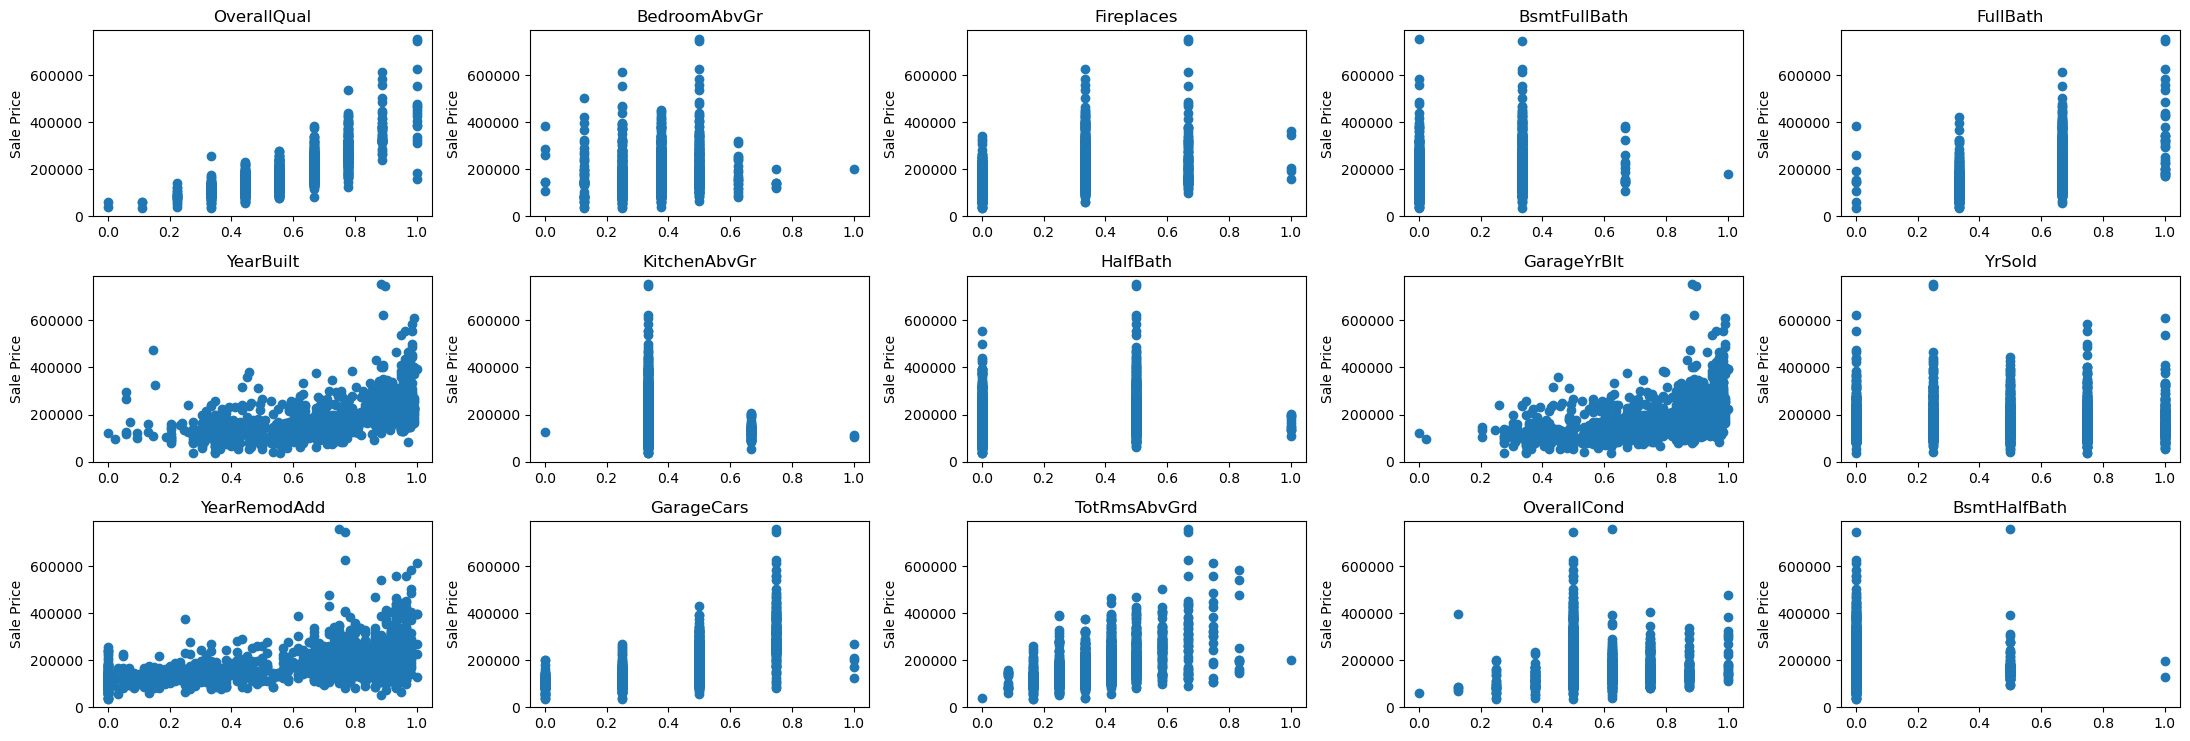

In [838]:
plt.figure(figsize = (22,22))
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(discrete_features),columns=discrete_features.columns)
for i,col in enumerate(scaled_df.columns):

    
    plt.subplot(9,5,i+1)
    
    x = scaled_df[col]
    y = train.SalePrice.values
    plt.scatter(x,y)
    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.ylabel("Sale Price")

    # Show the plot

plt.tight_layout()

## Mean of each discrete value

#### 1. I remove the point GarageYrBlt = 0 because it skews the plot. however it is clear that having no garage predicts low SalePrice. Perhaps it should be treated as the lowest year instead of 0

#### 2. It appears that the finnancial crisis in 2007 drops home prices alot. need to look deeper into that, and make sure it is not because of different counts per year.

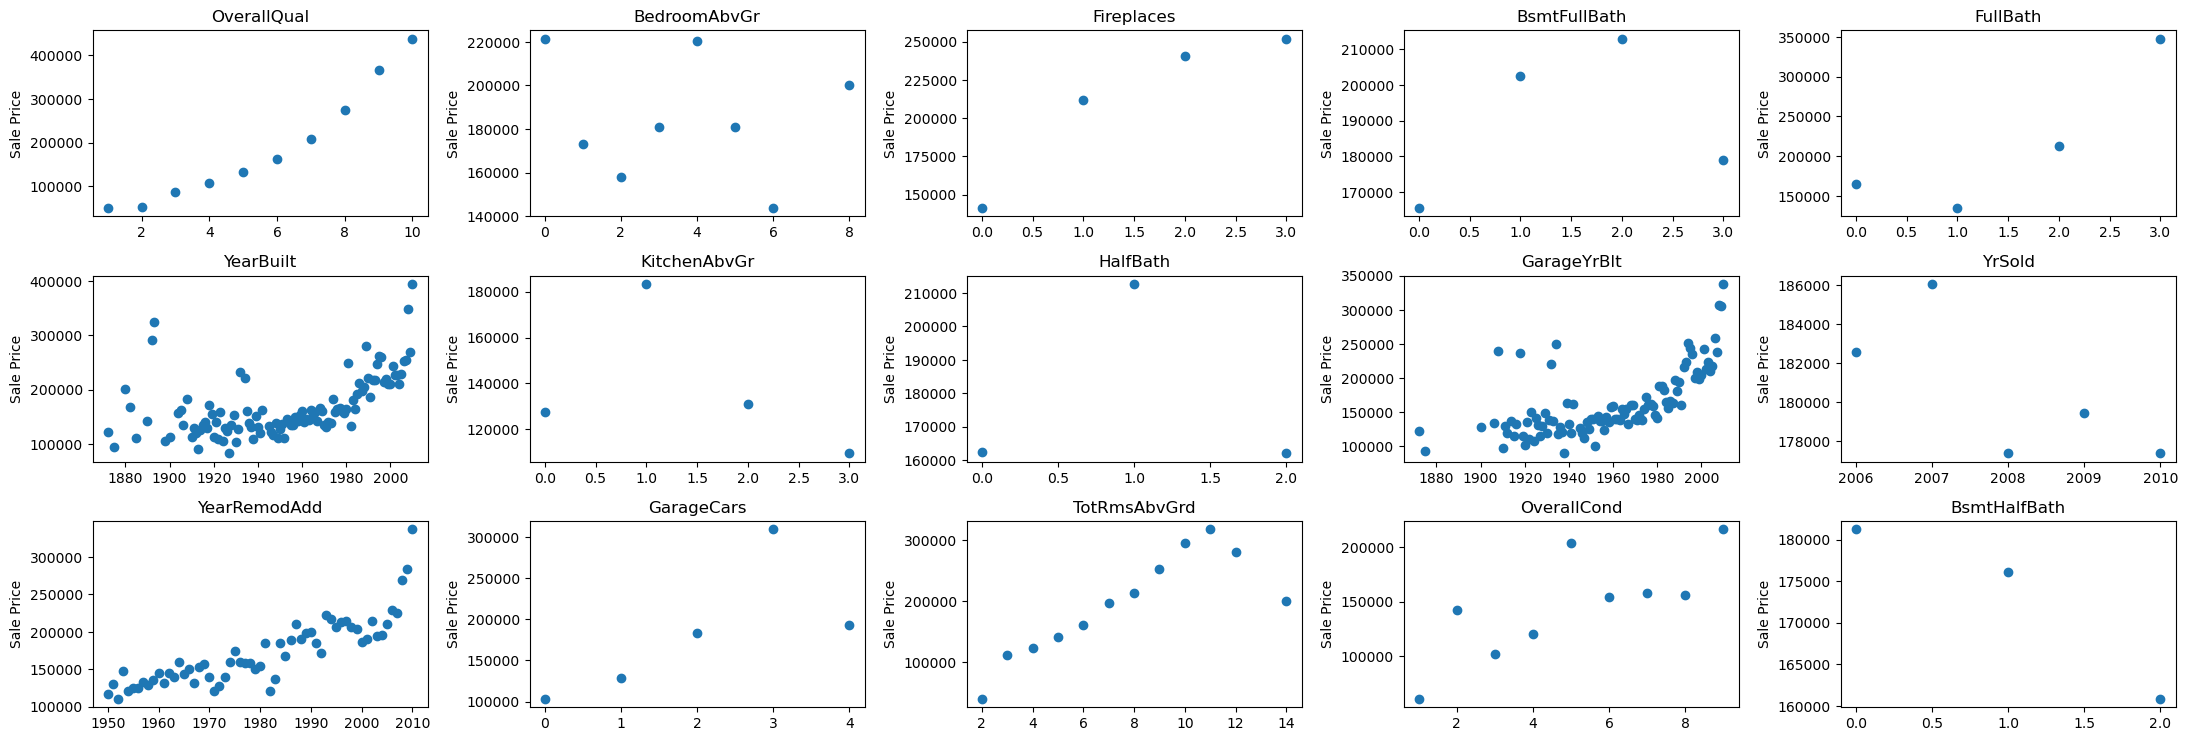

In [839]:
plt.figure(figsize=(22, 22))
scaler = MinMaxScaler()
scaled_df = discrete_features
for i, col in enumerate(scaled_df.columns):
    # if col != 'YearBuilt' and col != 'GarageYrBlt' and col != 'YearRemodAdd':
    plt.subplot(9, 5, i + 1)
    if col == 'GarageYrBlt':
        x = scaled_df[col].unique()
        x = x[x!= 0]
    else:

        x = scaled_df[col].unique()
    y = [train.loc[scaled_df[col] == val, 'SalePrice'].mean() for val in x]
    plt.scatter(x, y)
    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.ylabel("Sale Price")

plt.tight_layout()


## Count of discrete features

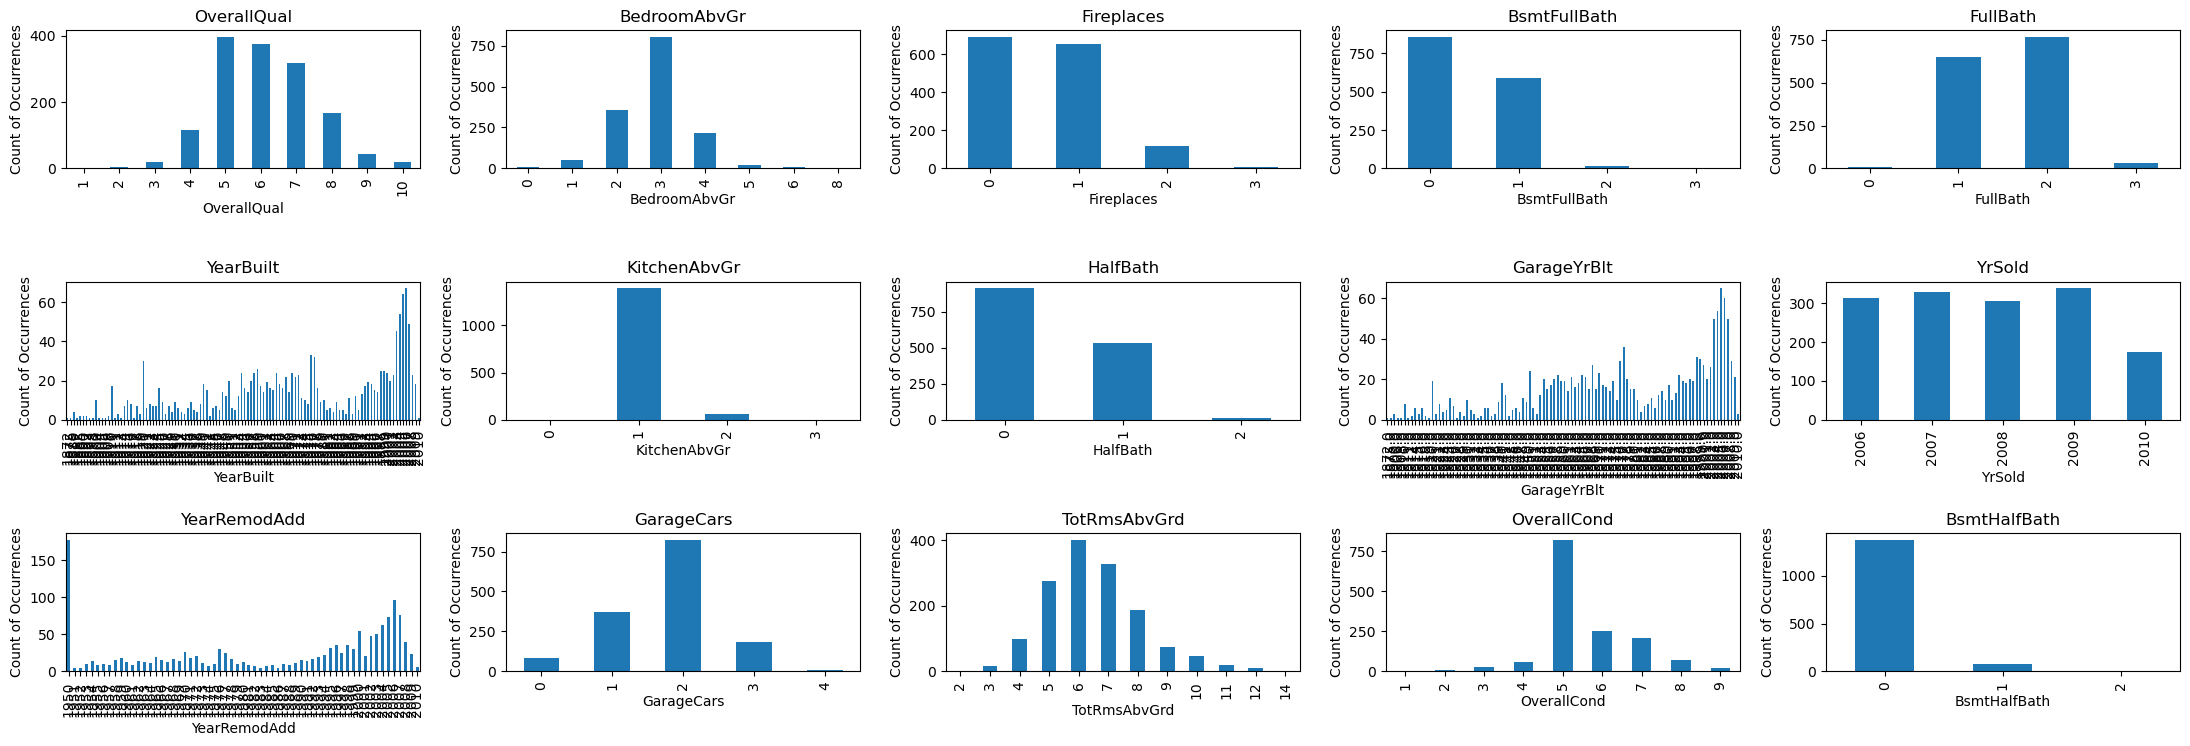

In [840]:

plt.figure(figsize = (22,22))
for i,col in enumerate(discrete_features.columns):
    plt.subplot(9,5,i+1)
    count_by_zoning = discrete_features.groupby(col).size()

    # Sort the count of occurrences in descending order
    

    # Plot the count of occurrences for each group
    count_by_zoning.plot.bar()

    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.xlabel(col)
    plt.ylabel("Count of Occurrences")

    # Show the plot

plt.tight_layout()


## <ins> Conclusions:

#### 1. Some features should be moved to ordinal features as they have clear ordinal behavior in respect to SalePrice that is not because of imbalance:
####    ['OverallQual', 'Fireplaces', 'BsmtFullBath', 'FullBath','YearBuilt', 'HalfBath', 'GarageYrBlt', 'YearRemodAdd','GarageCars','TotRmsAbvGrd','OverallCond']
#### Most of them are probably correlated to house size

#### 2. YrSold is a very important feature because of the finnancial crisis.

#### 3. Some features can't be used because of imbalance: ['BedroomAbvGr', 'KitchenAbvGr', 'BsmtHalfBath'] despite intuitively relation to SalePrice

#### 4. Change GarageYrBlt = 0 to 1890 ( originally, the oldest year is 1900), WHEN I DO THIS THE RMSE DROPS ALOT!

## Update feature dataframes according to conclusion #1:

In [841]:
columns =  ['OverallQual', 'Fireplaces', 'BsmtFullBath', 'FullBath','YearBuilt', 'HalfBath', 'GarageYrBlt', 'YearRemodAdd','GarageCars','TotRmsAbvGrd','OverallCond']
ordinal_features[columns] = discrete_features[columns]
discrete_features.drop(columns,axis=1,inplace=True)
# ordinal_features.GarageYrBlt[ordinal_features.GarageYrBlt == 0] = 1890

## <ins> Testing predictions using only ordinal features and YrSold:

#### Somehow adding YrSold barely decreases RMSE

#### Lowest RMSE: 37504 Max_depth =  19

#### <ins> With YrSold

In [842]:

# X = ordinal_features
# X['YrSold'] = discrete_features['YrSold']
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# for i in range(1,30,3):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse = mean_squared_error(y_test, y_pred,squared=False)

#     print("RMSE:", int(mse),"Max_depth = ",i)

#### <ins> Without YrSold

In [843]:
# X = ordinal_features
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# for i in range(1,30,3):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse = mean_squared_error(y_test, y_pred,squared=False)

#     print("RMSE:", int(mse),"Max_depth = ",i)


    

## Checking feature importance using RandomForest

In [844]:

# Load your continuous features and target variable
target = train.SalePrice

# Train a random forest regressor
regressor = RandomForestRegressor(n_estimators=500)
regressor.fit(ordinal_features, target)

# Obtain the feature importances
importances = regressor.feature_importances_

# Print the feature importances, sorted by importance
feature_importance = dict(zip(ordinal_features.columns, importances))
sorted_feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

for feature, importance in sorted_feature_importance.items():
    print("Feature: {}, Importance: {}".format(feature, importance))

    
important = list(sorted_feature_importance.keys())

Feature: OverallQual, Importance: 0.6320900671495612
Feature: TotRmsAbvGrd, Importance: 0.05007285889410262
Feature: GarageCars, Importance: 0.0487463271368169
Feature: YearRemodAdd, Importance: 0.03525990051533442
Feature: FullBath, Importance: 0.032615491306879005
Feature: FireplaceQu, Importance: 0.028111781496688287
Feature: YearBuilt, Importance: 0.025481785309055507
Feature: GarageYrBlt, Importance: 0.020849368206878268
Feature: BsmtExposure, Importance: 0.016462022083581204
Feature: BsmtFullBath, Importance: 0.014250454930686579
Feature: Fireplaces, Importance: 0.012682474913760792
Feature: GarageFinish, Importance: 0.011116304362087518
Feature: BsmtFinType1, Importance: 0.010667486115289644
Feature: BsmtQual, Importance: 0.010665186434476384
Feature: OverallCond, Importance: 0.010365211250505681
Feature: KitchenQual, Importance: 0.00816500378959742
Feature: HalfBath, Importance: 0.007534204405585528
Feature: ExterQual, Importance: 0.006868058821610869
Feature: HeatingQC, Import

In [845]:

# for indx in range(1,20):
#     X = ordinal_features[important[:indx]]
#     y = train.SalePrice
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#     mse = []
#     for i in range(1,30,3):
#         model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#         # fit the model on the training data
#         model.fit(X_train, y_train)

#         # make predictions on the test data
#         y_pred = model.predict(X_test)

#         # calculate the mean squared error of the predictions
#         mse.append(mean_squared_error(y_test, y_pred,squared=False))

#     print("RMSE:", np.min(mse), " Depth = ", 1 + np.argmin(mse)*3)



## Finally we have:

In [846]:
important_ordinal_features = ordinal_features[important[:14]]

## <ins>Looking deeper into continuous feautres:
### Plotting feature vs SalePrice


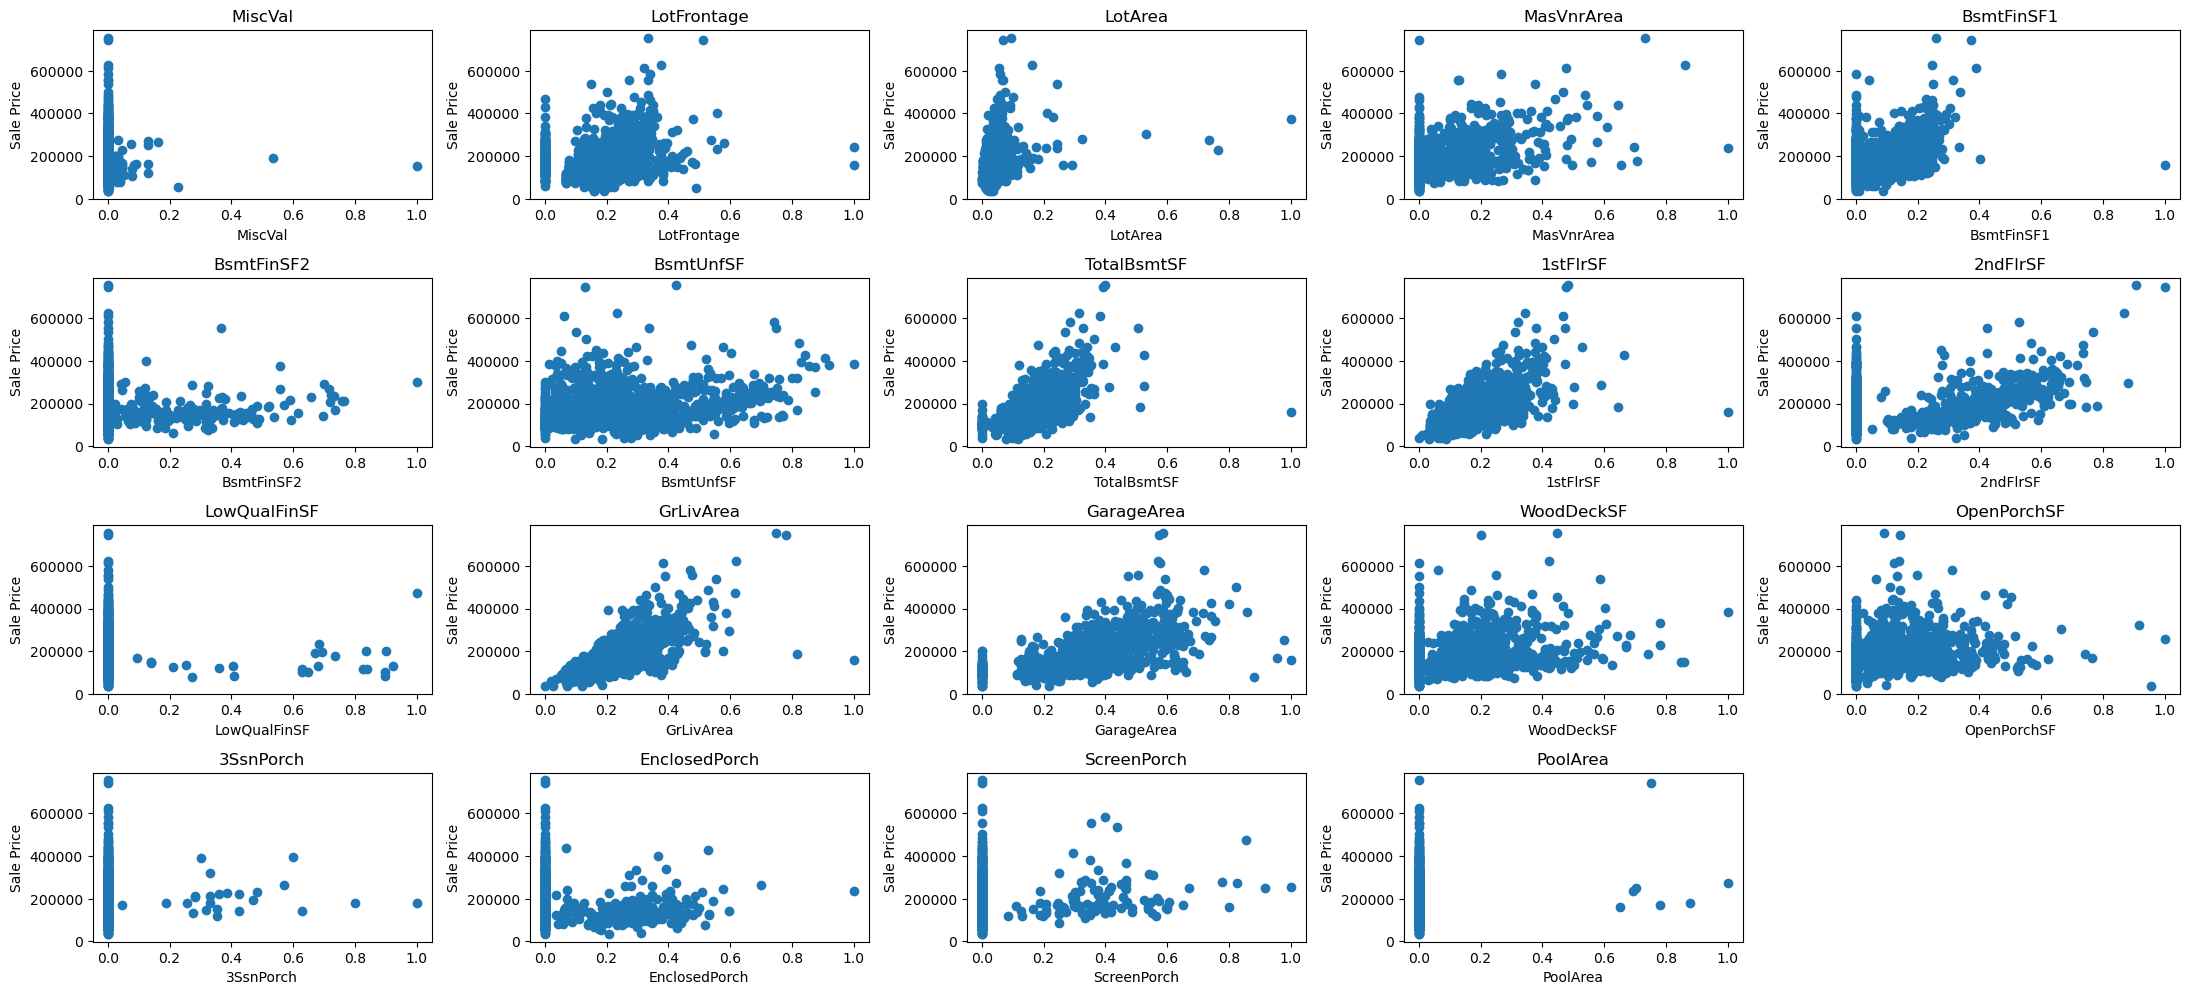

In [847]:
plt.figure(figsize = (22,22))
scaler = MinMaxScaler()
con_scaled = pd.DataFrame(scaler.fit_transform(continuous_features),columns=continuous_features.columns)
for i,col in enumerate(con_scaled):
    plt.subplot(9,5,i+1)
    
    x = con_scaled[col]
    y = train.SalePrice.values
    plt.scatter(x,y)
    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.xlabel(col)
    plt.ylabel("Sale Price")

    # Show the plot

plt.tight_layout()

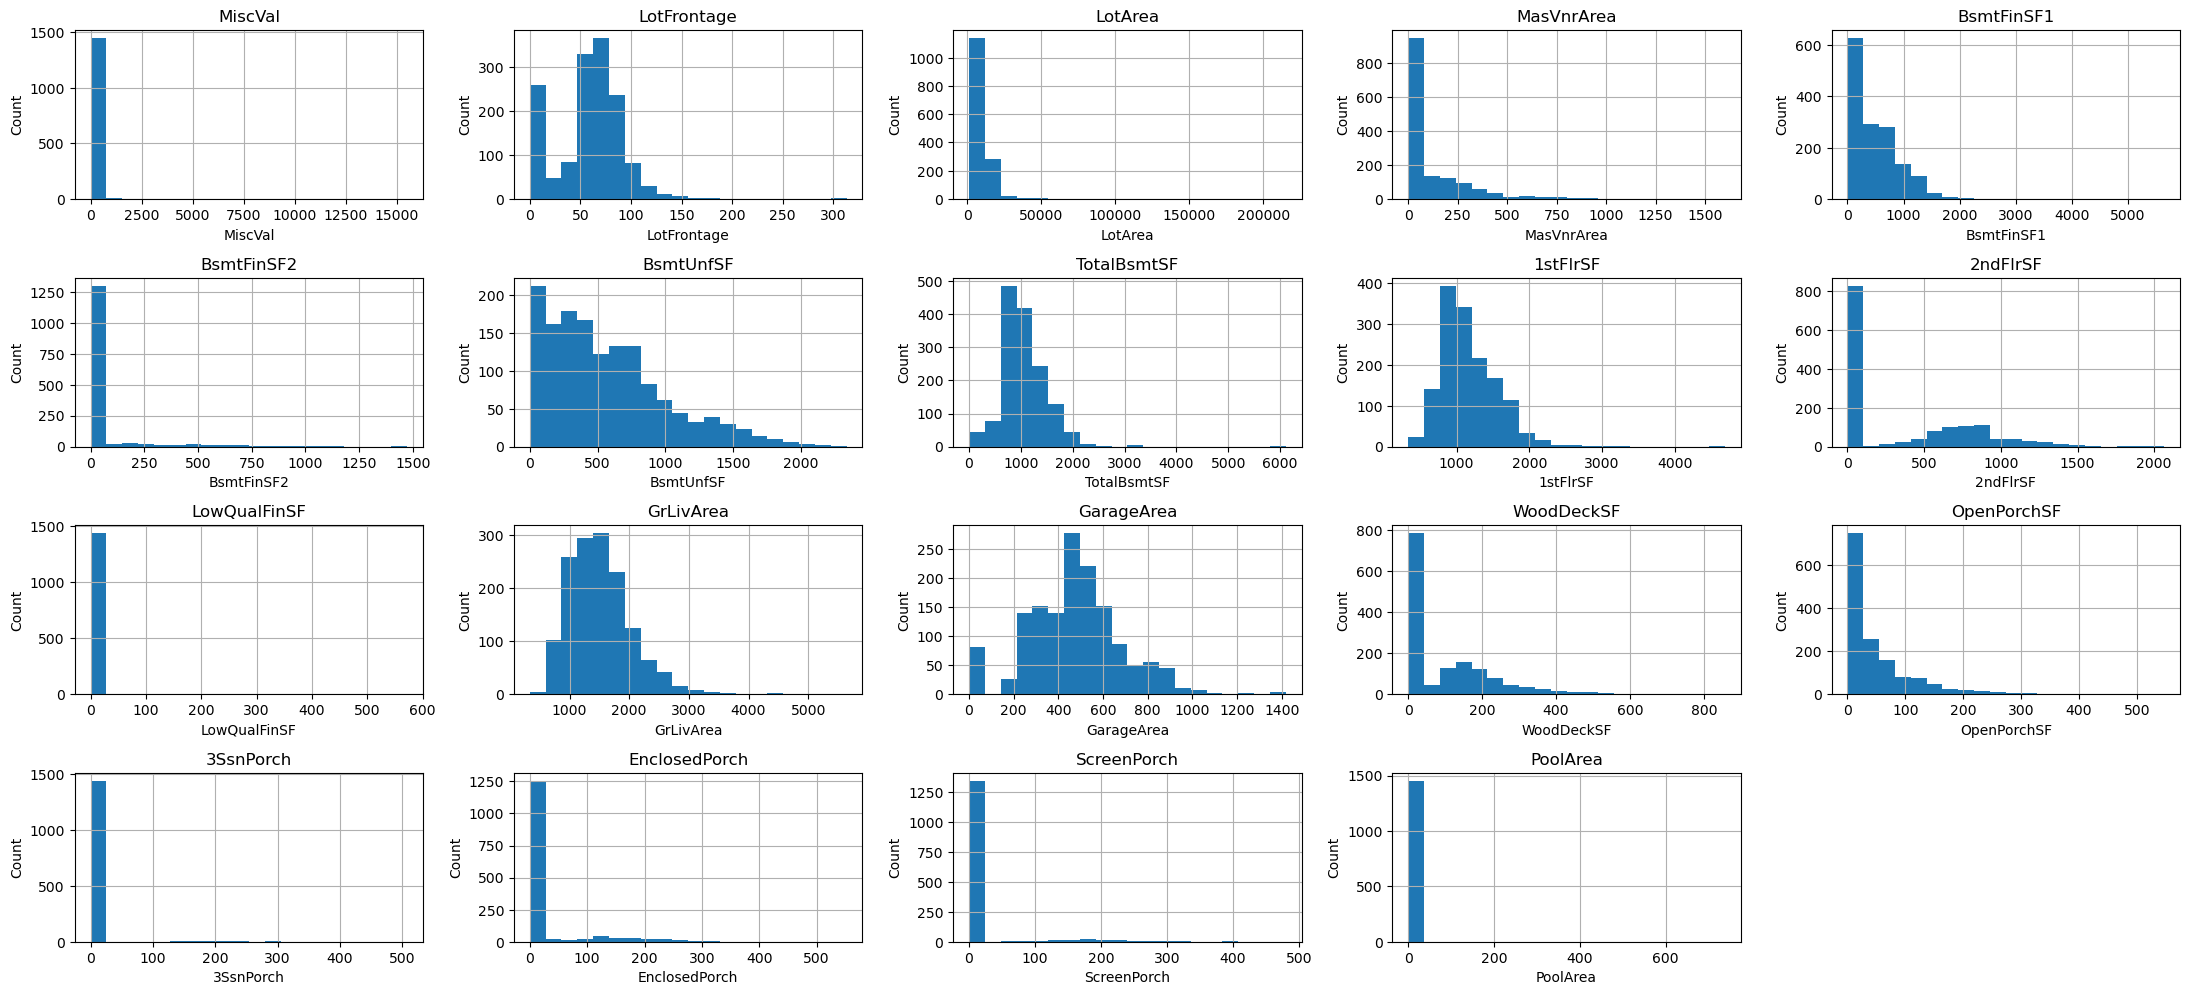

In [848]:
plt.figure(figsize = (22,22))
for i,col in enumerate(continuous_features):
    plt.subplot(9,5,i+1)
    
    continuous_features[col].hist(bins=20)
    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.xlabel(col)
    plt.ylabel("Count")

    # Show the plot

plt.tight_layout()

In [849]:


# Load your continuous features and target variable
target = train.SalePrice

# Train a random forest regressor
regressor = RandomForestRegressor(n_estimators=500)
regressor.fit(continuous_features, target)

# Obtain the feature importances
importances = regressor.feature_importances_

# Print the feature importances, sorted by importance
feature_importance = dict(zip(continuous_features.columns, importances))
sorted_feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

for feature, importance in sorted_feature_importance.items():
    print("Feature: {}, Importance: {}".format(feature, importance))

important = list(sorted_feature_importance.keys())

Feature: GrLivArea, Importance: 0.3594026598699191
Feature: GarageArea, Importance: 0.20829257132491663
Feature: TotalBsmtSF, Importance: 0.16098154554651536
Feature: 2ndFlrSF, Importance: 0.05494971141594108
Feature: BsmtFinSF1, Importance: 0.05478100875590607
Feature: 1stFlrSF, Importance: 0.032332956498777106
Feature: OpenPorchSF, Importance: 0.02725399825982753
Feature: LotArea, Importance: 0.023937097757393663
Feature: MasVnrArea, Importance: 0.021319044027622483
Feature: BsmtUnfSF, Importance: 0.01671010060591563
Feature: LotFrontage, Importance: 0.013560550108076375
Feature: WoodDeckSF, Importance: 0.013285251871346136
Feature: ScreenPorch, Importance: 0.004795406038836431
Feature: EnclosedPorch, Importance: 0.0036228244404472995
Feature: BsmtFinSF2, Importance: 0.0019637337048405415
Feature: PoolArea, Importance: 0.0011443246434525787
Feature: LowQualFinSF, Importance: 0.0006267103708655856
Feature: 3SsnPorch, Importance: 0.0006115594377215925
Feature: MiscVal, Importance: 0.00

In [850]:

# X = continuous_features
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# for i in range(1,30,3):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse = mean_squared_error(y_test, y_pred,squared=False)

#     print("RMSE:", int(mse),"Max_depth = ",i)

# Long loop looking for best continuous features

In [851]:

# for indx in range(3,11):
#     X = continuous_features[important[: indx]]
#     y = train.SalePrice
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#     mse = []
#     for i in range(1,30,3):
#         model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#         # fit the model on the training data
#         model.fit(X_train, y_train)

#         # make predictions on the test data
#         y_pred = model.predict(X_test)

#         # calculate the mean squared error of the predictions
#         mse.append(mean_squared_error(y_test, y_pred,squared=False))

#     print("RMSE:", np.min(mse), " Depth = ", 1 + np.argmin(mse)*3)



## So finally we would have imporant continuous features:

In [852]:
important_continuous_features = continuous_features[important[:8]]


## <inv> Finding Best Categorical Features

In [853]:

# One-hot encode the categorical features
categorical_features = pd.get_dummies(categorical_features)

# Train a random forest regressor
regressor = RandomForestRegressor()
regressor.fit(categorical_features, target)

# Obtain the feature importances
importances = regressor.feature_importances_

# Print the feature importances, sorted by importance
feature_importance = dict(zip(categorical_features.columns, importances))
sorted_feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

for feature, importance in sorted_feature_importance.items():
    print("Feature: {}, Importance: {}".format(feature, importance))

important = list(sorted_feature_importance.keys())

Feature: Foundation_PConc, Importance: 0.2518800184507665
Feature: RoofStyle_Hip, Importance: 0.062138406659630066
Feature: Neighborhood_NridgHt, Importance: 0.04974770009464212
Feature: Neighborhood_NoRidge, Importance: 0.03953407395462246
Feature: RoofMatl_WdShngl, Importance: 0.03748410020693499
Feature: GarageType_Attchd, Importance: 0.030332960610730316
Feature: MasVnrType_None, Importance: 0.024910599374291235
Feature: GarageType_Detchd, Importance: 0.022417100532922483
Feature: BldgType_1Fam, Importance: 0.01987688478739665
Feature: MasVnrType_Stone, Importance: 0.019400828932565055
Feature: MSSubClass_60, Importance: 0.018332125263743428
Feature: Neighborhood_Crawfor, Importance: 0.01705952078052013
Feature: Neighborhood_StoneBr, Importance: 0.016272056974117953
Feature: LotShape_Reg, Importance: 0.011132350205810049
Feature: MSZoning_RL, Importance: 0.010088406609300167
Feature: MSZoning_RM, Importance: 0.009293943321694462
Feature: LotConfig_CulDSac, Importance: 0.00908892169

In [854]:
# for indx in range(14,20,1):
#     X = categorical_features[important[: indx]]
#     y = train.SalePrice
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#     mse = []
#     for i in range(1,30,3):
#         model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#         # fit the model on the training data
#         model.fit(X_train, y_train)

#         # make predictions on the test data
#         y_pred = model.predict(X_test)

#         # calculate the mean squared error of the predictions
#         mse.append(mean_squared_error(y_test, y_pred,squared=False))

#     print("RMSE:", np.min(mse), " Depth = ", 1 + np.argmin(mse)*3, ' N_features = ', indx)

## And finally we have:

In [855]:
important_categorical_features = categorical_features[important[:17]]


## Checking RMSE with/without discrete features

#### <ins>With BedroomAbvGr

In [856]:
# X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# X['BedroomAbvGr'] = discrete_features['BedroomAbvGr']
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)


    

#### <ins>With Year sold

In [857]:
# X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# X['YrSold'] = discrete_features['YrSold']
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)


    

#### <ins> With KitchenAbvGr

In [858]:
# X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# X['KitchenAbvGr'] = discrete_features['KitchenAbvGr']
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)


    

#### <ins> With BsmtHalfBath

In [859]:
# X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# X['BsmtHalfBath'] = discrete_features['BsmtHalfBath']
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)


    

#### <ins> Without Discrete features

In [876]:
X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)


RMSE: 30319 Max_depth =  19


#### Seems like adding any discrete feature reduces the RMSE

### Check correlations of remaining features

### Very long loop searching for features that lower RMSE

#### results:
 Index(['OverallQual', 'GarageCars', 'TotRmsAbvGrd', 'YearRemodAdd', 'FullBath',
       'FireplaceQu', 'YearBuilt', 'GarageYrBlt', 'BsmtExposure',
       'BsmtFullBath', 'Fireplaces', 'BsmtQual', 'BsmtFinType1',
       'GarageFinish'],
      dtype='object')

In [861]:
X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# columns = X.columns
# keep = []
# for col in columns:
#     X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
#     y = train.SalePrice
#     X.drop( [col],axis=1,inplace=True)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
#     mse = []
#     for i in range(7,25,1):
#         model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#         # fit the model on the training data
#         model.fit(X_train, y_train)

#         # make predictions on the test data
#         y_pred = model.predict(X_test)

#         # calculate the mean squared error of the predictions
#         mse.append(mean_squared_error(y_test, y_pred,squared=False))

#     print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7, ' Column Dropped = ',col)
#     if int(np.min(mse)) > 30200:
#         keep.append(col)

In [862]:
keep = ['OverallQual', 'GarageCars', 'TotRmsAbvGrd', 'YearRemodAdd', 'FullBath',
       'FireplaceQu', 'YearBuilt', 'GarageYrBlt', 'BsmtExposure',
       'BsmtFullBath', 'Fireplaces', 'BsmtFinType1',
       'GarageFinish']

Find best model

In [990]:
# X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# # X['area_rooms_ratio'] = X.LotArea / X.TotRmsAbvGrd
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)


RMSE: 30319 Max_depth =  19


Test best model

In [992]:
X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
y = train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = RandomForestRegressor(n_estimators=500,max_depth=12,random_state=0)

# fit the model on the training data
model.fit(X_train, y_train)

# make predictions on the test data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mean_squared_error(y_test, y_pred,squared=False)

30131.142665356376

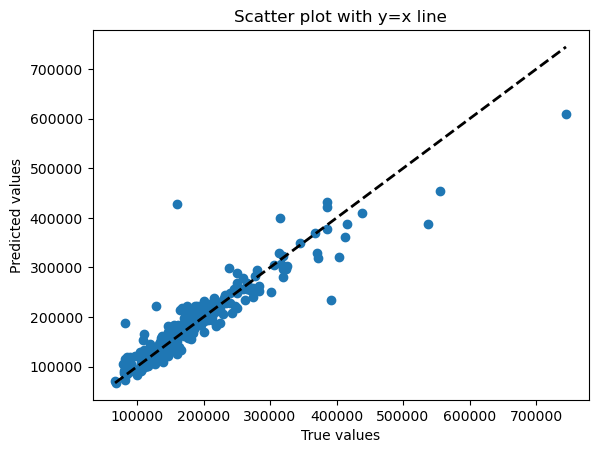

In [1000]:
plt.scatter( y_test,y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.ylabel('Predicted values')
plt.xlabel('True values')
plt.title('Scatter plot with y=x line')
plt.show()


In [1002]:
X_test['SalePrice'] = y_test
X_test['Prediction'] = np.int64(y_pred)
X_test['Error'] = np.int64(np.abs(y_test - y_pred))

wrong_index = X_test[X_test.SalePrice > 300000].sort_values('Error',ascending=False).iloc[:15].index

1. Most have above average rooms
2. Most have above average Fireplaces
3. Except for the second most wrong, all are above average LotArea 
4. Most have big difference between OverallQual and OverallCond - Try creating a feature OverallQual - OverallCond - Didnt do much
5. Mostly above average year built

In [ ]:
X_test[X_test.SalePrice > 300000].sort_values('Error',ascending=False).iloc[:15]

In [1007]:
train.LotArea.mean()

16692.130434782608

In [1008]:
train.loc[wrong_index]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
688,20,RL,60.0,8089,Pave,NaN,Reg,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,8,6,2007,2007,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,945,Unf,0,474,1419,GasA,Ex,Y,SBrkr,1419,0,0,1419,1,0,2,0,2,1,Gd,7,Typ,1,Gd,Attchd,2007.0,RFn,2,567,TA,TA,Y,140,0,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,392000
769,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,CulDSac,Mod,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,Ex,TA,PConc,Gd,TA,Gd,ALQ,1416,Unf,0,234,1650,GasA,Ex,Y,SBrkr,1690,1589,0,3279,1,0,3,1,4,1,Ex,12,Mod,1,Gd,BuiltIn,2003.0,Fin,3,841,TA,TA,Y,503,36,0,0,210,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000
1182,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
440,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1767,ALQ,539,788,3094,GasA,Ex,Y,SBrkr,2402,0,0,2402,1,0,2,0,2,1,Ex,10,Typ,2,Gd,Attchd,2008.0,Fin,3,672,TA,TA,Y,0,72,0,0,170,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
1359,20,RL,129.0,16737,Pave,NaN,Reg,Lvl,AllPub,FR3,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2004,2005,Hip,CompShg,VinylSd,VinylSd,BrkFace,66.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1447,Unf,0,533,1980,GasA,Ex,Y,SBrkr,1980,0,0,1980,1,0,2,0,3,1,Ex,8,Typ,1,Gd,Attchd,2004.0,Fin,3,770,TA,TA,Y,194,45,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Normal,315000
231,60,RL,174.0,15138,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,1995,1996,Gable,CompShg,VinylSd,VinylSd,BrkFace,506.0,Gd,TA,PConc,Gd,TA,No,GLQ,689,Unf,0,773,1462,GasA,Ex,Y,SBrkr,1490,1304,0,2794,1,0,2,1,4,1,Ex,9,Typ,1,TA,Attchd,1995.0,Fin,3,810,TA,TA,Y,0,146,202,0,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal,403000
678,20,RL,80.0,11844,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,1Story,8,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,464.0,Gd,TA,PConc,Ex,TA,Mn,Unf,0,Unf,0,2046,2046,GasA,Ex,Y,SBrkr,2046,0,0,2046,0,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2008.0,Fin,3,834,TA,TA,Y,322,82,0,0,0,0,NaN,NaN,NaN,0,7,2009,New,Partial,372500
161,60,RL,110.0,13688,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,664.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1016,Unf,0,556,1572,GasA,Ex,Y,SBrkr,1572,1096,0,2668,1,0,2,1,3,1,Ex,10,Typ,2,Gd,BuiltIn,2003.0,Fin,3,726,TA,TA,Y,400,0,0,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Normal,412500
322,60,RL,86.0,10380,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1986,1987,Gable,CompShg,Plywood,Plywood,BrkFace,172.0,Gd,TA,CBlock,TA,TA,Gd,LwQ,28,ALQ,1474,0,1502,GasA,Ex,Y,SBrkr,1553,1177,0,2730,1,0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1987.0,Fin,2,576,TA,TA,Y,201,96,0,0,0,0,NaN,MnPrv,NaN,0,8,2007,WD,Normal,301000
825,20,RL,114.0,14803,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,PosN,PosN,1Fam,1Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,BrkFace,816.0,Ex,TA,PConc,Ex,TA,

## GOOD FEATURES FOUND IN EXPLORATIONS
1. X.LotArea / X.TotRmsAbvGrd a very slight improvment on validation

In [1017]:
X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
indx = X.index
X['Condition'] = train.loc[indx,'OverallQual'] * train.loc[indx,'OverallCond']
y = train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

mse = []
for i in range(7,25,1):
    model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred = model.predict(X_test)

    # calculate the mean squared error of the predictions
    mse.append(mean_squared_error(y_test, y_pred,squared=False))

print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)

RMSE: 30389 Max_depth =  16


# Looking for patterns in houses with SalePrice > 300k

In [1018]:
above_300k = train[train.SalePrice > 300000]


